## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)

This is a starter notebook for the guided project [Tweet Emotion Recognition with TensorFlow](https://www.coursera.org/projects/tweet-emotion-tensorflow)

A complete version of this notebook is available in the course resources

---

## Task 1: Introduction

## Task 2: Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [47]:
!pip install nlp

In [48]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.8.0


## Task 3: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [49]:
dataset = nlp.load_dataset('emotion')

Using custom data configuration default


In [50]:
dataset

{'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [51]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [52]:
def get_tweet(data):
  tweets = [x['text'] for x in data]
  labels = [x['label'] for x in data]
  return tweets, labels 

In [53]:
tweets, labels = get_tweet(train)

In [54]:
tweets[0], labels[0] 

('i didnt feel humiliated', 'sadness')

## Task 4: Tokenizer

1. Tokenizing the tweets

In [55]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [56]:
tokenizer = Tokenizer(num_words = 10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

## Task 5: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

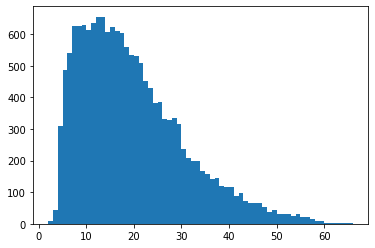

In [57]:
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins = len(set(lengths)))
plt.show()

In [58]:
maxlen = 50 
from tensorflow.keras.preprocessing.sequence import pad_sequences 

In [59]:
def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating='post', padding = 'post', maxlen = maxlen)
  return padded

In [60]:
padded_train_seq = get_sequences(tokenizer, tweets)

In [61]:
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## Task 6: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [62]:
classes = set(labels)
print(classes) 

{'fear', 'anger', 'sadness', 'love', 'surprise', 'joy'}


(array([4666.,    0., 2159.,    0., 1304.,    0.,  572.,    0., 1937.,
           0., 5362.]),
 array([0.        , 0.45454545, 0.90909091, 1.36363636, 1.81818182,
        2.27272727, 2.72727273, 3.18181818, 3.63636364, 4.09090909,
        4.54545455, 5.        ]),
 <a list of 11 Patch objects>)

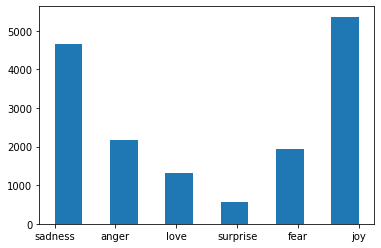

In [63]:
plt.hist(labels, bins = 11)

In [68]:
class_to_index = dict((c,i) for i, c in enumerate(classes))
index_to_class = dict((v,k) for k, v in class_to_index.items())

In [69]:
class_to_index

{'anger': 1, 'fear': 0, 'joy': 5, 'love': 3, 'sadness': 2, 'surprise': 4}

In [70]:
index_to_class

{0: 'fear', 1: 'anger', 2: 'sadness', 3: 'love', 4: 'surprise', 5: 'joy'}

In [72]:
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

In [73]:
train_labels = names_to_ids(labels)
print(train_labels[0])

2


## Task 7: Creating the Model

1. Creating the model
2. Compiling the model

In [76]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(10000, 16, input_length = maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences = True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
        tf.keras.layers.Dense(6, activation = 'softmax')
])

model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam' , 
    metrics = ['accuracy']
)

In [77]:
model.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 16)            160000    
                                                                 
 bidirectional_1 (Bidirectio  (None, 50, 40)           5920      
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


## Task 8: Training the Model

1. Preparing a validation set
2. Training the model

In [80]:
val_tweets, val_lables = get_tweet(val) 
val_seq = get_sequences(tokenizer, val_tweets) 
val_labels = names_to_ids(val_lables) 

In [81]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 2)

In [82]:
h = model.fit(
    padded_train_seq, train_labels, 
    validation_data = (val_seq, val_labels), 
    epochs = 20,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience = 2)
    ]
)

Epoch 1/20
500/500 [==============================] - 40s 62ms/step - loss: 1.3082 - accuracy: 0.4804 - val_loss: 0.7734 - val_accuracy: 0.7250
Epoch 2/20
500/500 [==============================] - 29s 58ms/step - loss: 0.4725 - accuracy: 0.8375 - val_loss: 0.4604 - val_accuracy: 0.8575
Epoch 3/20
500/500 [==============================] - 29s 58ms/step - loss: 0.2494 - accuracy: 0.9207 - val_loss: 0.4097 - val_accuracy: 0.8720
Epoch 4/20
500/500 [==============================] - 29s 58ms/step - loss: 0.1687 - accuracy: 0.9465 - val_loss: 0.3986 - val_accuracy: 0.8760
Epoch 5/20
500/500 [==============================] - 29s 58ms/step - loss: 0.1225 - accuracy: 0.9612 - val_loss: 0.5134 - val_accuracy: 0.8725
Epoch 6/20
500/500 [==============================] - 29s 58ms/step - loss: 0.1007 - accuracy: 0.9677 - val_loss: 0.4673 - val_accuracy: 0.8785
Epoch 7/20
500/500 [==============================] - 29s 59ms/step - loss: 0.0874 - accuracy: 0.9731 - val_loss: 0.4539 - val_accuracy:

## Task 9: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

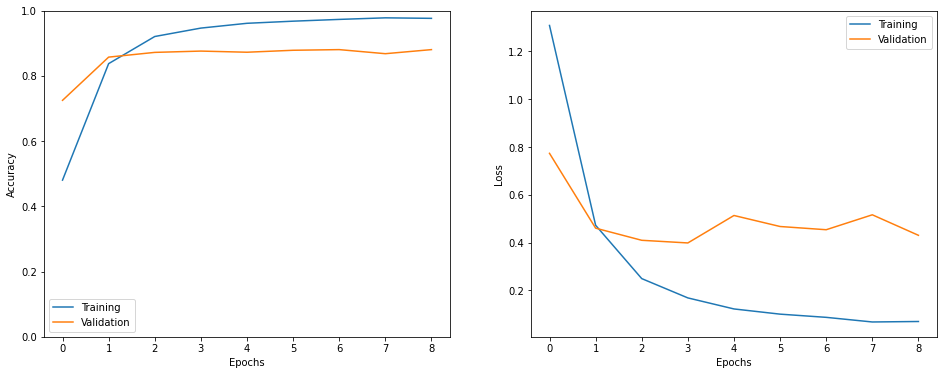

In [83]:
show_history(h) 

In [85]:
test_tweets, test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [86]:
_ = model.evaluate(test_seq, test_labels)

63/63 [==============================] - 1s 20ms/step - loss: 0.4216 - accuracy: 0.8785


In [87]:
i = random.randint(0, len(test_labels) - 1)
print('Sentence:' , test_tweets[i])
print('Emotion:', index_to_class[test_labels[i]])
p = model.predict(np.expand_dims(test_seq[i], axis = 0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]
print('Predicted Emotion:', pred_class)

Sentence: i feel rather privileged to have witnessed the great man in action it really was impossible for a novice like me to work out just which one of the four identical looking riders was he
Emotion: joy
Predicted Emotion: joy


In [94]:
preds = np.argmax(model.predict(test_seq), axis=-1)

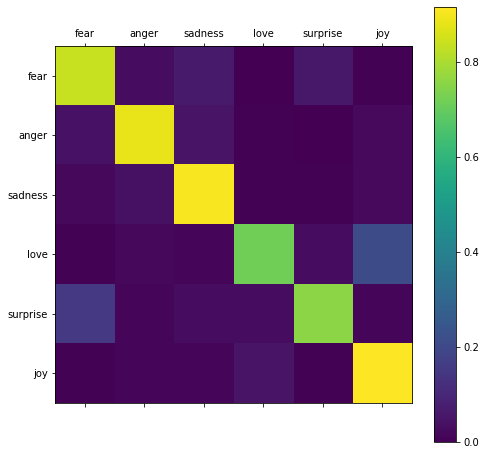

In [95]:
show_confusion_matrix(test_labels, preds, list(classes))